In [25]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import GaussianSymmetrizedKLKernel, ScaleKernel
from gpytorch.means import ConstantMean

import pandas as pd

data_dir = '../../data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data = pd.read_csv(data_dir + 'concat/MWRA_seagrant_concat_batch.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
sal_and_ta = data[(data['SAL (PSU)'].notnull()) & (data['TA in (mmol/kgSW)'].notnull())]

In [50]:
sorted(list(sal_and_ta['SAL (PSU)']))

[18.3,
 23.8,
 23.9,
 25.4,
 26.6,
 26.6,
 26.7,
 27.049560546875,
 27.14,
 27.14,
 27.5441093444824,
 27.9,
 28.0,
 28.1187705993652,
 28.3921051025391,
 28.3921051025391,
 28.9931602478027,
 29.0,
 29.06,
 29.06,
 29.1466865539551,
 29.1783504486084,
 29.2,
 29.2042121887207,
 29.2261581420898,
 29.2521324157715,
 29.2589111328125,
 29.27,
 29.3731632232666,
 29.4,
 29.4145755767822,
 29.4789333343506,
 29.4856986999512,
 29.5,
 29.5,
 29.6,
 29.6,
 29.6261215209961,
 29.6285133361816,
 29.6285133361816,
 29.6571350097656,
 29.67,
 29.7,
 29.7,
 29.7,
 29.8226280212402,
 29.8604793548584,
 29.8680057525635,
 29.8777351379395,
 29.8883457183838,
 29.8905429840088,
 29.8984603881836,
 29.9,
 29.9331569671631,
 29.9491348266602,
 30.0045986175537,
 30.0045986175537,
 30.0130500793457,
 30.0447025299072,
 30.0599842071533,
 30.0785045623779,
 30.129940032959,
 30.1682071685791,
 30.2,
 30.21,
 30.2476749420166,
 30.3,
 30.4,
 30.4,
 30.4473876953125,
 30.5,
 30.5,
 30.5074157714844,
 30.

In [33]:
train_x = sal_and_ta['SAL (PSU)'].values
train_y = sal_and_ta['TA in (mmol/kgSW)'].values
# Convert to torch tensor
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()

In [15]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

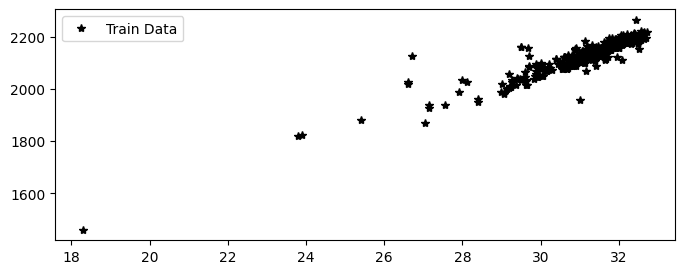

In [34]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x, train_y, fmt="k*", label="Train Data")
ax.legend()

In [55]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [56]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [57]:
training_iter = 500
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

AttributeError: 'NoneType' object has no attribute 'item'

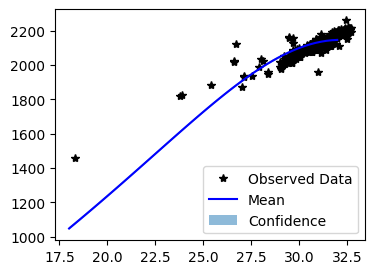

In [54]:
# Get into evaluation (predictive posterior) mode
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(18, 32, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])